В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
data_path = r'C:\Users\olha.koltun\OneDrive - Trico\ML Course\data\bank-customer-churn-prediction-dlu-course-c-2'

raw_df = pd.read_csv(os.path.join(data_path, 'train.csv'))

raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
raw_df['Exited'].value_counts()

Exited
0.0    11948
1.0     3052
Name: count, dtype: int64

In [5]:
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)

train_df.shape : (12000, 14)
val_df.shape : (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [6]:
input_cols = list(raw_df.columns)[3:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

print('train_inputs.shape :', train_inputs.shape)
print('val_inputs.shape :', val_inputs.shape)
print('train_targets.shape :', train_targets.shape)
print('val_targets.shape :', val_targets.shape)

train_inputs.shape : (12000, 10)
val_inputs.shape : (3000, 10)
train_targets.shape : (12000,)
val_targets.shape : (3000,)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [7]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [8]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [9]:
# Identify binary numeric columns from the numeric columns
binary_numeric_cols = [col for col in numeric_cols if train_inputs[col].nunique() == 2]

# Remaining numeric columns after excluding binary columns
numeric_cols = [col for col in numeric_cols if col not in binary_numeric_cols]

# Print the results
print('Binary Numeric Columns:', binary_numeric_cols)
print('Continuous Numeric Columns:', numeric_cols)

Binary Numeric Columns: ['HasCrCard', 'IsActiveMember']
Continuous Numeric Columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


In [10]:
# Scale numeric features
scaler = StandardScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

### Рішення передобробки

1. **Визначення бінарних числових колонок**:
   - Виділили колонки з двома унікальними значеннями (0 та 1) і залишили їх без обробки, оскільки вони вже готові до використання. Це спрощує роботу моделі, зберігаючи вхідну структуру даних.

2. **Масштабування числових ознак**:
   - Застосували `StandardScaler`, щоб стандартизувати числові дані. Це допомагає покращити точність і стабільність моделей, які чутливі до масштабу ознак.

3. **Кодування категоріальних ознак**:
   - Використали `OneHotEncoder` для перетворення текстових категорій на числові бінарні стовпці, які модель може розуміти.
   - Параметр `handle_unknown='ignore'` допоміг уникнути помилок, якщо в тестових даних є нові категорії.


In [11]:
from IPython.display import display

print("Train Inputs (first 5 rows):")
display(train_inputs.head())

print("Validation Inputs (first 5 rows):")
display(val_inputs.head())

Train Inputs (first 5 rows):


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.320187,France,Male,-0.944682,-1.447264,1.475464,-1.108193,1.0,1.0,0.569450,1.0,0.0,0.0,0.0,1.0
10393,0.347838,France,Female,0.161227,-1.087792,2.254434,-1.108193,1.0,0.0,0.603803,1.0,0.0,0.0,1.0,0.0
80,0.638166,Germany,Male,-0.330288,0.350096,1.223831,0.769304,1.0,0.0,1.238026,0.0,1.0,0.0,0.0,1.0
3365,0.140460,Spain,Male,2.495924,-1.806736,-0.717950,0.769304,0.0,1.0,-1.457116,0.0,0.0,1.0,0.0,1.0
12236,0.665816,France,Male,-2.050591,-0.728320,-0.717950,0.769304,1.0,1.0,0.670629,1.0,0.0,0.0,0.0,1.0


Validation Inputs (first 5 rows):


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.762592,Germany,Male,1.021379,-1.447264,1.214543,4.524299,1.0,1.0,-0.988144,0.0,1.0,0.0,0.0,1.0
3646,-0.910252,France,Male,0.406985,-0.009376,-0.717950,0.769304,1.0,1.0,-1.750392,1.0,0.0,0.0,0.0,1.0
5306,0.997620,France,Female,0.038348,-1.087792,-0.717950,0.769304,0.0,1.0,-0.022404,1.0,0.0,0.0,1.0,0.0
652,0.195761,France,Female,0.652742,-0.368848,1.881867,-1.108193,0.0,1.0,-0.139723,1.0,0.0,0.0,1.0,0.0
2627,0.264887,Spain,Female,-0.944682,-0.368848,-0.717950,0.769304,1.0,0.0,0.563519,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [12]:
path = os.path.join(os.getcwd(), 'parquet_files') 
os.makedirs(path, exist_ok=True) 

train_inputs.to_parquet(os.path.join(path, 'train_inputs.parquet'))
val_inputs.to_parquet(os.path.join(path, 'val_inputs.parquet'))

pd.DataFrame(train_targets).to_parquet(os.path.join(path, 'train_targets.parquet'))
pd.DataFrame(val_targets).to_parquet(os.path.join(path, 'val_targets.parquet'))
                                     
os.listdir(path) 

['train_inputs.parquet',
 'train_targets.parquet',
 'val_inputs.parquet',
 'val_targets.parquet']

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [13]:
# Load processed data from disk
train_inputs = pd.read_parquet(os.path.join(path, 'train_inputs.parquet'))
val_inputs = pd.read_parquet(os.path.join(path, 'val_inputs.parquet'))

train_targets = pd.read_parquet(os.path.join(path, 'train_targets.parquet'))[target_col]
val_targets = pd.read_parquet(os.path.join(path, 'val_targets.parquet'))[target_col]

X_train = train_inputs[numeric_cols + binary_numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + binary_numeric_cols + encoded_cols]

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Evaluation on Training Data:
Training F1 Score: 0.64


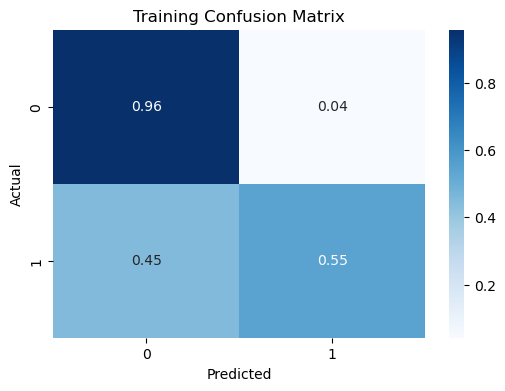

Training AUROC: 0.88


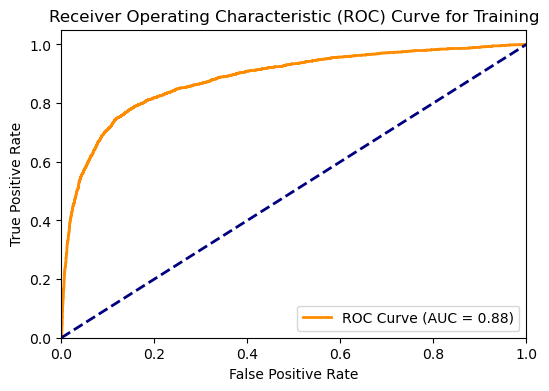


Evaluation on Validation Data:
Validation F1 Score: 0.64


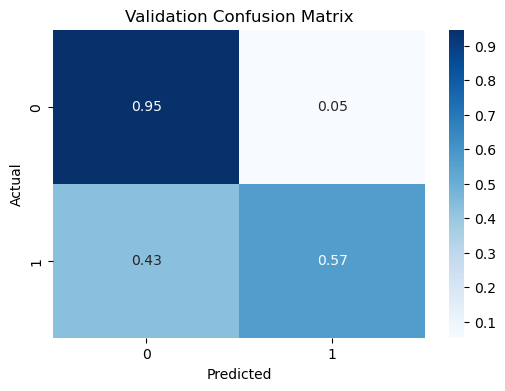

Validation AUROC: 0.88


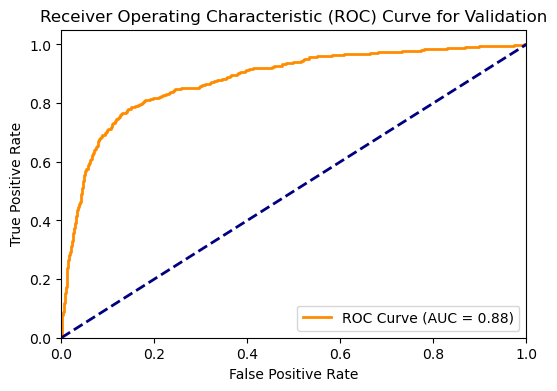

In [14]:
# Combined evaluation function
def predict_and_evaluate_model(inputs, targets, name=''):
    # Predict probabilities
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Apply classification threshold of 0.5
    y_preds = (y_pred_proba >= 0.5).astype(int)

    # Compute F1 Score
    f1 = f1_score(targets, y_preds)
    print(f"{name} F1 Score: {f1:.2f}")

    # Compute Confusion Matrix
    cf_matrix = confusion_matrix(targets, y_preds, normalize='true')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(f"{name} AUROC: {roc_auc:.2f}")

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    return y_preds

# Evaluate the model on training and validation datasets
print('Evaluation on Training Data:')
train_preds = predict_and_evaluate_model(X_train, train_targets, name='Training')

print('\nEvaluation on Validation Data:')
val_preds = predict_and_evaluate_model(X_val, val_targets, name='Validation')

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [15]:
majority_class = train_targets.mode()[0]
print(f'Majority class: {majority_class}')

def predict_majority(X):
    return np.full(len(X), majority_class)

train_majority_preds = predict_majority(X_train)
val_majority_preds = predict_majority(X_val)

# Calculate Accuracy for the majority class model
train_majority_acc = accuracy_score(train_targets, train_majority_preds)
val_majority_acc = accuracy_score(val_targets, val_majority_preds)

print(f'Majority class model - Accuracy on training data: {train_majority_acc:.2f}')
print(f'Majority class model - Accuracy on validation data: {val_majority_acc:.2f}')

# Calculate Accuracy for the trained model
train_acc = accuracy_score(train_targets, train_preds)
val_acc = accuracy_score(val_targets, val_preds)

print(f'Trained model - Accuracy on training data: {train_acc:.2f}')
print(f'Trained model - Accuracy on validation data: {val_acc:.2f}')

Majority class: 0.0
Majority class model - Accuracy on training data: 0.80
Majority class model - Accuracy on validation data: 0.80
Trained model - Accuracy on training data: 0.87
Trained model - Accuracy on validation data: 0.87


Натренована модель досягає **87% точності**, що перевищує **80% точності** мажоритарної моделі на 7%. Це свідчить, що модель навчилася розпізнавати закономірності в даних і має **задовільну якість**, але може потребувати покращень для точнішої роботи з міноритарним класом.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [16]:
bank_customer_churn_prediction = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'binary_numeric_cols': binary_numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

joblib.dump(bank_customer_churn_prediction, 'bank_customer_churn_prediction.joblib')

['bank_customer_churn_prediction.joblib']

In [17]:
loaded_data = joblib.load('bank_customer_churn_prediction.joblib')

model_2 = loaded_data['model']

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [18]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, binary_numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + binary_numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [19]:
predict_raw_df(scaler, encoder, numeric_cols, binary_numeric_cols, categorical_cols, raw_df[:5])

array([0.00562897, 0.03338872, 0.38088582, 0.38008015, 0.9792151 ])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [20]:
test_raw_df = pd.read_csv(os.path.join(data_path, 'test.csv'))

test_raw_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, binary_numeric_cols, categorical_cols, test_raw_df)

test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Exited
0,15000,15594796.0,Chu,-1.034678,Germany,Male,-0.944682,-1.087792,1.720173,-1.108193,1.0,1.0,0.875226,0.0,1.0,0.0,0.0,1.0,0.069445
1,15001,15642821.0,Mazzi,-1.490909,France,Male,0.161227,-0.009376,-0.717950,0.769304,1.0,1.0,-1.109098,1.0,0.0,0.0,0.0,1.0,0.033348
2,15002,15716284.0,Onyekachi,0.651991,France,Male,0.652742,1.069040,-0.717950,0.769304,1.0,0.0,0.850584,1.0,0.0,0.0,0.0,1.0,0.153414
3,15003,15785078.0,Martin,0.804068,Spain,Male,0.898500,-0.728320,-0.717950,-1.108193,1.0,1.0,1.073044,0.0,0.0,1.0,0.0,1.0,0.199254
4,15004,15662955.0,Kenechukwu,-0.924077,Spain,Male,0.652742,1.069040,-0.717950,0.769304,1.0,1.0,0.563521,0.0,0.0,1.0,0.0,1.0,0.054301


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [21]:
submission_df = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [22]:
submission_df['Exited'] = test_raw_df.set_index('id').loc[submission_df['id'], 'Exited'].values

print('First 5 rows of the submission file:')
print(submission_df.head())

submission_df.to_csv(os.path.join(data_path, 'submission_log_reg.csv'), index=False)
print('Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!')

First 5 rows of the submission file:
      id    Exited
0  15000  0.069445
1  15001  0.033348
2  15002  0.153414
3  15003  0.199254
4  15004  0.054301
Submission file saved as submission_log_reg.csv. Ready for upload to Kaggle!
